Extractor de características

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import hsv_to_rgb
# from matplotlib import cm
from matplotlib import colors

In [2]:
path = 'fruit_dataset'

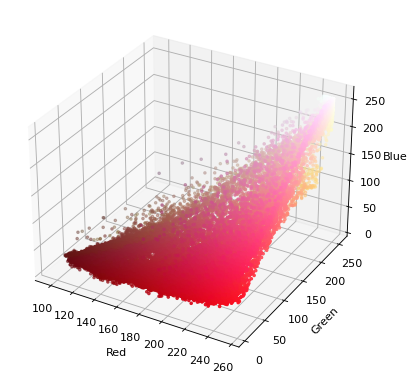

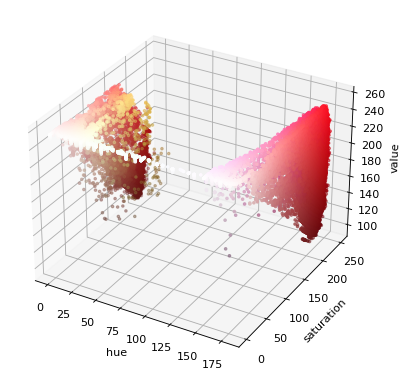

In [3]:
# segmentar fruta
img = cv2.imread(path+'\\training\\fruit_9.jpg',1)
img_original = img
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
r,g,b = cv2.split(img)
fig = plt.figure(figsize=(8,6),dpi=80)
axis = fig.add_subplot(1,1,1,projection="3d")

# Configuración de color de píxeles
pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1],3))
# print(pixel_colors)
# Normalizado
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
# Convertir a lista
pixel_colors = norm(pixel_colors).tolist()

# Mostrar diagrama de dispersión 3D
axis.scatter(r.flatten(),g.flatten(),b.flatten(),facecolors=pixel_colors,marker='.')
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

# Visualización en espacio hsv
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(hsv_img)
fig = plt.figure(figsize=(8,6),dpi=80)
axis = fig.add_subplot(1,1,1,projection="3d")

# Configuración de color de píxeles
pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1],3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
# Convertir a lista
pixel_colors = norm(pixel_colors).tolist()


# Mostrar diagrama de dispersión 3D
axis.scatter(h.flatten(),s.flatten(),v.flatten(),facecolors=pixel_colors,marker='.')
axis.set_xlabel("hue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()


In [4]:
light_yellow = np.array([15,100,25], np.uint8)
dark_yellow = np.array([38,255,255],np.uint8)



In [5]:
h_mean = np.array(h)
positives = h_mean > 0
if positives.any():
    h_mean = h_mean[positives].mean()
    
s_mean = np.array(s)
positives = s_mean > 0
if positives.any():
    s_mean = s_mean[positives].mean()

v_mean = np.array(v)
positives = v_mean > 0
if positives.any():
    v_mean = v_mean[positives].mean()

In [108]:
print(h_mean)
print(s_mean)
print(v_mean)

146.16919591844916
174.89743589743588
201.17417907714844


In [109]:
print(np.mean(h))
print(np.mean(s))
print(np.mean(v))

111.25729370117188
145.7122802734375
201.17417907714844
